# Traveling salesman Problem (TSP)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from itertools import permutations 
import string
import math
import networkx
from typing import Hashable
%matplotlib inline

#set seed
random.seed(time.time() * 1000)

Some more information about the TSP can be found in [this thesis](https://etheses.whiterose.ac.uk/19011/) and [wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem). In this example we will simulate some _dummy_ and short instances. The [National TSP instances](https://www.math.uwaterloo.ca/tsp/world/countries.html) shows some long computations and illustrates why exhaustive search become infeasible rapidly.

## Problem definition

_Given a set of cities along with the cost of travel between each pair of them, traveling salesman problem, or TSP for short, is to find the cheapest way of visiting all the cities and returning the starting point._[1]

[1] David L Applegate, Robert E Bixby, Vasek Chvatal, and William J Cook. The traveling salesman problem: a computational study. Princeton university press, 2011.


## A simple example

This example uses five cities named A, B, C, D, E.  The distance between each city is in km, but randomly generated. So each time the cells are executed a new solution may exist. 

We compute the number of pair of cities. We use a complete graph to compute the number of vertices and therefore $\frac{n(n-1)}{2}$. An explanation can be found [here](https://mathworld.wolfram.com/CompleteGraph.html)



In [3]:
print("Cities:")
no_cities = 5
cities = set(string.ascii_uppercase[:no_cities])


Cities:


In [4]:
def build_dist_table_rand(no_cities:int)->[]:
    """
    Build a table of distances between each city. We consider each city a vertex in a digraph
    and the distances the edges.
    
    preconditions: no_cities is greater than 2.
    postconditions: returns a list of tuples. Each tuple represent a distinct permulation 
    of pairs of cities with a distance in km. The list is sorted alphabetically by vertices. 
    The number of explected rows is (no_cities * (no_cities-1))/2
    """
    assert(no_cities > 2)
    # initialise some values
    cities         = list(string.ascii_uppercase[:no_cities])
    pairs          = int((no_cities * (no_cities-1))/2)
    distances      = [random.randrange(10, 2000) for x in range(0,pairs, 1)]
    all_poss_pairs = list(permutations(cities,2))
    distinct_pairs = all_poss_pairs[0: no_cities-1]
    all_cities     = range(1,no_cities-1,1)
    dist_table     = []
   
    
    # reduce pairs to distinct pairs
    for city_no  in all_cities:
        first = city_no * (no_cities-1)
        last  = (city_no+1) * (no_cities) - (city_no + 1)
        pairs = all_poss_pairs[first:last]
        distinct_pairs = distinct_pairs + pairs[city_no: len(pairs)]
    
    # matches distances and pairs to build dist table
    indices = range(0, len(distances), 1)
    for index in indices:
        entry = (distinct_pairs[index][0], distinct_pairs[index][1], distances[index])
        dist_table.append(entry)
   
    return dist_table



In [5]:
all_distances = build_dist_table_rand(no_cities)
all_distances

[('A', 'B', 1837),
 ('A', 'C', 581),
 ('A', 'D', 1316),
 ('A', 'E', 1065),
 ('B', 'C', 136),
 ('B', 'D', 1509),
 ('B', 'E', 557),
 ('C', 'D', 1664),
 ('C', 'E', 1669),
 ('D', 'E', 752)]

### Let's compute length of a tour



In [6]:
def find_dist_between_cities(first_city:str, second_city:str, all_distances:[]) -> int:
    """
    search for the distance between two given cities. 
    preconditions: 
        - first and second city must be a non-empty string
        - all_distances must be not empty and contains tuples of 3 elements.
    postconditions: returns the distance between two cities. If the cities are not found, 
    then a zero length is returned.
    """
    assert(len(first_city) > 0)
    assert(len(second_city) > 0)
    assert(len(all_distances) > 0)
    assert(len(all_distances[0]) == 3)
    
    distance = 0
    
    if first_city < second_city:
        first  = first_city
        second = second_city
    else:
        first  = second_city
        second = first_city
        
    len_dist  = len(all_distances)
    index = 0 
    while index < len_dist:
        if (all_distances[index][0] == first) & (all_distances[index][1] == second):
            distance = all_distances[index][2]
            index = len_dist
        else :
            if index < (len_dist-1):
                index = index + 1
            else:
                index = len_dist
            
    return distance

print(find_dist_between_cities("A","B", all_distances))
print(find_dist_between_cities("E","D", all_distances))
print(find_dist_between_cities("D","D", all_distances))
        
        

1837
752
0


In [7]:
def total_length_tour(tour:[], all_distances:[]) -> int:
    """
    compute the total length of a given tour
    preconditions: 
        - tour is not empty
        - all_distances must be not empty and contains tuples of 3 elements.
    postconditions: returns the 
    """
    assert(len(tour) > 0)
    assert(len(all_distances) > 0)
    assert(len(all_distances[0]) == 3)
    
    tour_length = 0
    indices = range(0, len(tour), 1)
    for index in indices:

        if index == len(tour)-1:
            first  = tour[len(tour)-1]
            second = tour[0]
        else:
            first  = tour[index]
            second = tour[index+1]
        distance = find_dist_between_cities(first,second, all_distances)
        tour_length = tour_length + distance
        
    return tour_length

print(total_length_tour(["A", "B", "C", "D", "E"],all_distances))
print(total_length_tour(["E", "D", "C", "B", "A"],all_distances))
    

5454
5454


### Exhaustive search to find the shortest tour

In [8]:
def find_shortest_tour(cities:str, all_distances:[]) -> ():
    """
    compute the shortest tour for n cities.
    preconditions: a non-empty string of cities and a non-empty distance table.
    postconditions: return a tuple with made of a tour and its total length.  The shortest 
    tour is search exhaustively through all the possible permutations of cities; 
    that is a total of squared number of cities in total. 
    """
    
    assert(len(cities) > 0)
    assert(len(all_distances) > 0)
    
    # All permutations
    tours = list(permutations(cities,len(cities)))
    best_tour = (tours[0],total_length_tour(tours[0],all_distances))
    most_tours = tours[1:len(tours)-1]
    
    for tour in most_tours:
        current_tour = (tour ,total_length_tour(tour ,all_distances))
        if (current_tour[1] < best_tour[1]):
            best_tour = current_tour
    
    return best_tour    

In [9]:
print("The minimum tour length is : ")
%time find_shortest_tour(cities, all_distances)

The minimum tour length is : 
CPU times: user 425 µs, sys: 406 µs, total: 831 µs
Wall time: 837 µs


(('A', 'D', 'E', 'B', 'C'), 3342)

## Let's explore other instances with more cities

We explore the running time and the theta complexity. 

## Three cities

In [10]:
no_cities = 3
cities    = set(string.ascii_uppercase[:no_cities])
print("maximum of number of tours : ", math.pow(no_cities,2))
print(cities)

maximum of number of tours :  9.0
{'C', 'B', 'A'}


In [11]:
all_distances = build_dist_table_rand(no_cities)
all_distances

[('A', 'B', 262), ('A', 'C', 1488), ('B', 'C', 203)]

In [12]:
print("The minimum tour length is : ")
%time find_shortest_tour(cities, all_distances)

The minimum tour length is : 
CPU times: user 22 µs, sys: 20 µs, total: 42 µs
Wall time: 50.1 µs


(('C', 'B', 'A'), 1953)

## 7 cities

In [13]:


no_cities = 7
cities    = set(string.ascii_uppercase[:no_cities])
print("maximum of number of tours : ", math.pow(no_cities,2))
print(cities)

all_distances = build_dist_table_rand(no_cities)
all_distances

print("The minimum tour length is : ")
%time find_shortest_tour(cities, all_distances)## Three cities

maximum of number of tours :  49.0
{'F', 'A', 'D', 'C', 'G', 'B', 'E'}
The minimum tour length is : 
CPU times: user 73.8 ms, sys: 773 µs, total: 74.5 ms
Wall time: 73.9 ms


(('F', 'D', 'G', 'A', 'C', 'B', 'E'), 2437)

## 10 cities 

In [14]:
no_cities = 10
cities    = set(string.ascii_uppercase[:no_cities])
print("maximum of number of tours : ", math.pow(no_cities,2))
print(cities)

all_distances = build_dist_table_rand(no_cities)
all_distances

print("The minimum tour length is : ")
%time find_shortest_tour(cities, all_distances)

maximum of number of tours :  100.0
{'F', 'A', 'D', 'C', 'H', 'J', 'I', 'G', 'B', 'E'}
The minimum tour length is : 
CPU times: user 2min 14s, sys: 426 ms, total: 2min 14s
Wall time: 2min 15s


(('F', 'A', 'E', 'B', 'D', 'G', 'H', 'J', 'C', 'I'), 3866)

## Complexity


[Complexity of exhaustive search and TSP](https://crab.rutgers.edu/users/guyk/es.pdf)

The exhaustive search itself remains $\theta(n)$. However, generating all the possible permutations of tours is $\theta(n!)$ [see explanations](https://leadcoding.in/find-all-the-permutations-of-an-array/). Therefore, the exponential complexity is higher than the linear complexity. So we assume the complexity is a factorial. 

Looking at the execution time - which are different from the time complexity - 10 cities tooks minutes rather milliseconds. It demonstrates how quickly exhaustive search can become obsolete and infeasible to use. 

Text(0.5, 1.0, 'Time complexity')

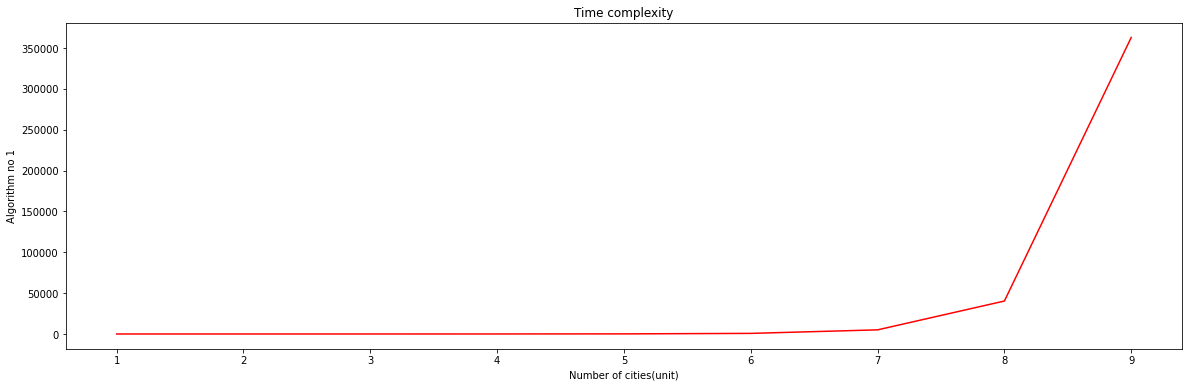

In [46]:
xs = range(1,10, 1) 
ys = [math.factorial(x) for x in xs]
plt.figure(figsize=(20,6))
plt.plot(xs, ys, color = "red",  )
plt.xlabel("Number of cities(unit)")
plt.ylabel("Algorithm no 1")
plt.title("Time complexity")


In [51]:
math.factorial(3)

6

In [52]:
math.factorial(5)

120

In [53]:
math.factorial(7)

5040

In [54]:
math.factorial(10)

3628800

## Let's build a directed graph

[wikipedia](https://en.wikipedia.org/wiki/Directed_graph)



In [42]:
class DiGraph:
    """A directed graph with hashable node objects.

    Edges are between different nodes.
    There's at most one edge from one node to another.
    """

    def __init__(self):
        self.out = dict()   # a map of nodes to their out-neighbours

    def has_node(self, node: Hashable) -> bool:
        """Return True if and only if the graph has the node."""
        return node in self.out

    def has_edge(self, start: Hashable, end: Hashable) -> bool:
        """Return True if and only if edge start -> end exists.

        Preconditions: self.has_node(start) and self.has_node(end)
        """
        return end in self.out[start]

    def add_node(self, node: Hashable) -> None:
        """Add the node to the graph.

        Preconditions: not self.has_node(node)
        """
        self.out[node] = set()

    def add_edge(self, start: Hashable, end: Hashable) -> None:
        """Add edge start -> end to the graph.

        If the edge already exists, do nothing.

        Preconditions:
        self.has_node(start) and self.has_node(end) and start != end
        """
        self.out[start].add(end)

    def remove_node(self, node: Hashable) -> None:
        """Remove the node and all its attached edges.

        Preconditions: self.has_node(node)
        """
        self.out.pop(node)
        for start in self.out:
            self.remove_edge(start, node)

    def remove_edge(self, start: Hashable, end: Hashable) -> None:
        """Remove edge start -> end from the graph.

        If the edge doesn't exist, do nothing.

        Preconditions: self.has_node(start) and self.has_node(end)
        """
        self.out[start].discard(end)

    def nodes(self) -> set:
        """Return the graph's nodes."""
        all_nodes = set()
        for node in self.out:
            all_nodes.add(node)
        return all_nodes

    def edges(self) -> set:
        """Return the graph's edges as a set of pairs (start, end)."""
        all_edges = set()
        for start in self.out:
            for end in self.out[start]:
                all_edges.add( (start, end) )
        return all_edges

    def out_neighbours(self, node: Hashable) -> set:
        """Return the out-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return set(self.out[node])  # return a copy

    def out_degree(self, node: Hashable) -> int:
        """Return the number of out-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return len(self.out[node])

    def in_neighbours(self, node: Hashable) -> set:
        """Return the in-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        start_nodes = set()
        for start in self.out:
            if self.has_edge(start, node):
                start_nodes.add(start)
        return start_nodes

    def in_degree(self, node: Hashable) -> int:
        """Return the number of in-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return len(self.in_neighbours(node))

    def neighbours(self, node: Hashable) -> set:
        """Return the in- and out-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return self.out_neighbours(node).union(self.in_neighbours(node))

    def degree(self, node: Hashable) -> int:
        """Return the number of in- and out-going edges of the node.

        Preconditions: self.has_node(node)
        """
        return self.in_degree(node) + self.out_degree(node)

    def draw(self) -> None:
        """Draw the graph."""
        if type(self) == DiGraph:
            graph = networkx.DiGraph()
        else:
            graph = networkx.Graph()
        graph.add_nodes_from(self.nodes())
        graph.add_edges_from(self.edges())
        networkx.draw(graph, with_labels=True,
            node_size=1000, node_color='lightblue',
            font_size=12, font_weight='bold')
        
class WeightedDiGraph(DiGraph):
    """A weighted directed graph with hashable node objects.

    Edges are between different nodes.
    There's at most one edge from one node to another.
    Edges have weights, which can be floats or integers.
    """

    def add_node(self, node: Hashable) -> None:
        """Add the node to the graph.

        Preconditions: not self.has_node(node)
        """
        self.out[node] = dict() # a map of out-neighbours to weights

    def add_edge(self, start: Hashable, end: Hashable, weight: float) -> None:
        """Add edge start -> end, with the given weight, to the graph.

        If the edge already exists, set its weight.

        Preconditions:
        self.has_node(start) and self.has_node(end) and start != end
        """
        self.out[start][end] = weight

    def weight(self, start: Hashable, end: Hashable) -> float:
        """Return the weight of edge start -> end or infinity if it doesn't exist.

        Preconditions: self.has_node(start) and self.has_node(end)
        """
        if self.has_edge(start, end):
            return self.out[start][end]
        else:
            return math.inf

    def remove_edge(self, start: Hashable, end: Hashable) -> None:
        """Remove edge start -> end from the graph.

        If the edge doesn't exist, do nothing.

        Preconditions: self.has_node(start) and self.has_node(end)
        """
        if self.has_edge(start, end):
            self.out[start].pop(end)

    def edges(self) -> set:
        """Return the graph's edges as a set of triples (start, end, weight)."""
        all_edges = set()
        for start in self.out:
            for (end, weight) in self.out[start].items():
                all_edges.add( (start, end, weight) )
        return all_edges

    def out_neighbours(self, node: Hashable) -> set:
        """Return the out-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return set(self.out[node].keys())

    def draw(self) -> None:
        """Draw the graph."""
        if type(self) == WeightedDiGraph:
            graph = networkx.DiGraph()
        else:
            graph = networkx.Graph()
        graph.add_nodes_from(self.nodes())
        for (node1, node2, weight) in self.edges():
            graph.add_edge(node1, node2, w=weight)
        pos = networkx.spring_layout(graph)
        networkx.draw(graph, pos, with_labels=True,
            node_size=1000, node_color='lightblue',
            font_size=12, font_weight='bold')
        networkx.draw_networkx_edge_labels(graph, pos,
            edge_labels=networkx.get_edge_attributes(graph, 'w'))


Add the nodes to the directed graph; each city becomes a node.

Cities:


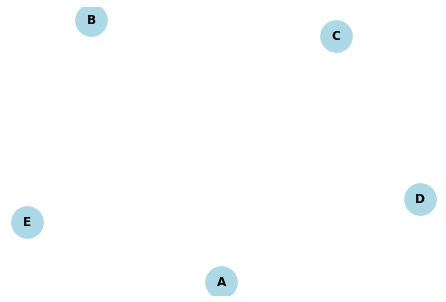

In [80]:
print("Cities:")
no_cities = 5
cities = set(string.ascii_uppercase[:no_cities])

instance = WeightedDiGraph()
for city in cities:
    instance.add_node(city)
    

    
instance.draw()


Add the edges with the weight. Each weigth is a distance.

In [86]:
all_distances = build_dist_table_rand(no_cities)
all_distances

[('A', 'B', 694),
 ('A', 'C', 1385),
 ('A', 'D', 387),
 ('A', 'E', 1431),
 ('B', 'C', 453),
 ('B', 'D', 454),
 ('B', 'E', 602),
 ('C', 'D', 238),
 ('C', 'E', 887),
 ('D', 'E', 1735)]

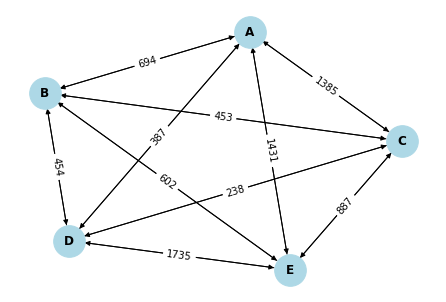

In [88]:
for entry in all_distances:
    instance.add_edge(entry[0],entry[1], entry[2])
    instance.add_edge(entry[1],entry[0], entry[2])

instance.draw()


## Dijkstra algorithm

[Dijkstra algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)


https://www.bogotobogo.com/python/python_graph_data_structures.php

In [89]:
from heapq import heappush, heappop

def dijkstra(graph: WeightedDiGraph, start: Hashable) -> WeightedDiGraph:
    """Return a shortest path from start to each reachable node.

    Preconditions:
    - graph.has_node(start)
    - node objects are comparable
    - no weight is negative
    """
    visited = WeightedDiGraph()
    visited.add_node(start)

    # create min-priority queue of tuples (cost, (A, B, weight))
    # cost is total weight from start to B via shortest path to A
    unprocessed = []    # min-priority queue
    for neighbour in graph.out_neighbours(start):
        weight = graph.weight(start, neighbour)
        heappush(unprocessed, (weight, (start, neighbour, weight)) )

    while len(unprocessed) > 0:
        info = heappop(unprocessed)
        cost = info[0]
        edge = info[1]
        previous = edge[0]
        current = edge[1]
        weight = edge[2]

        if not visited.has_node(current):
            visited.add_node(current)
            visited.add_edge(previous, current, weight)
            for neighbour in graph.out_neighbours(current):
                weight = graph.weight(current, neighbour)
                edge = (current, neighbour, weight)
                heappush(unprocessed, (cost + weight, edge) )
    return visited


In [91]:
tour = dijkstra(instance, "A")
print(list(tour.nodes()))
print(total_length_tour(list(tour.nodes()), all_distances))


['A', 'D', 'C', 'B', 'E']
3111
